GPCC precipitation data (original distributor): https://opendata.dwd.de/climate_environment/GPCC/html/fulldata-monthly_v2022_doi_download.html

Area delimitation: https://pt.wikipedia.org/wiki/Geografia_da_Regi%C3%A3o_Nordeste_do_Brasil

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc

# Graphic
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import seaborn as sns
from cartopy.crs import EqualEarth, PlateCarree
import geopandas as gpd
from shapely.geometry import Point

# PCA/EOF Analysis
from xeofs.models import EOF, EOFRotator, ExtendedEOF

# Statistics
from scipy import stats
from scipy.interpolate import griddata

In [2]:
# Set graphic style
plt.style.use('seaborn')

C:\Users\mathe\AppData\Local\Temp\ipykernel_22856\3617314069.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
def plot_basemap(df, score, title, score_name, grid_size=1000, llcrnrlon=-180, llcrnrlat=-75, urcrnrlon=180, urcrnrlat=85, figsize_x=15, figsize_y=15):
    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)

    fig, ax = plt.subplots(figsize=(figsize_x, figsize_y), dpi=800)

    # Extract longitude, latitude, and scores
    longitudes = gdf['lon'].values
    latitudes = gdf['lat'].values
    scores = gdf[score].values

    # Set up the Basemap
    m = Basemap(projection='cyl', llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat, urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat, resolution='i', ax=ax)

    # Generate a grid
    lon_grid = np.linspace(longitudes.min(), longitudes.max(), grid_size)
    lat_grid = np.linspace(latitudes.min(), latitudes.max(), grid_size)
    lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

    # Interpolate the scores onto the grid
    score_grid = griddata((longitudes, latitudes), scores, (lon_mesh, lat_mesh), method='linear')

    # Convert the grid to map coordinates
    x, y = m(lon_mesh, lat_mesh)

    # Draw map boundaries and features
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries(linewidth=1, linestyle='solid', color='k')

    # Plot the filled contour map
    cs = m.contourf(x, y, score_grid, cmap='jet', levels=300)

    plt.ylabel("Latitude", fontsize=15, labelpad=35)
    plt.xlabel("Longitude", fontsize=15, labelpad=20)
    cbar = m.colorbar(cs, location='right', pad="3%")
    cbar.set_label(score_name, fontsize=13)
    plt.title(title, fontsize=15)

    # Display the plot
    plt.show()

# Precipitation data preprocessing (SPI + regional precipitation series)

In [4]:
def nc_to_pandas(fp: str) -> pd.DataFrame:
    ds = xr.open_dataset(fp)
    df = ds.to_dataframe()
    return df.reset_index()

In [5]:
file_paths = [
    '../data/gpcc_data/full_data_monthly_v2022_1921_1930_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_1931_1940_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_1941_1950_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_1951_1960_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_1961_1970_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_1971_1980_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_1981_1990_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_1991_2000_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_2001_2010_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_2011_2020_25.nc'
]

dfs = [nc_to_pandas(fp) for fp in file_paths]
df = pd.concat(dfs)[['lon', 'lat', 'time', 'precip']]

# Sorting by 'time' to ensure continuity
df = df.sort_values(by='time').reset_index(drop=True)

In [15]:
np.sort(df['lat'].unique())

array([-88.75, -86.25, -83.75, -81.25, -78.75, -76.25, -73.75, -71.25,
       -68.75, -66.25, -63.75, -61.25, -58.75, -56.25, -53.75, -51.25,
       -48.75, -46.25, -43.75, -41.25, -38.75, -36.25, -33.75, -31.25,
       -28.75, -26.25, -23.75, -21.25, -18.75, -16.25, -13.75, -11.25,
        -8.75,  -6.25,  -3.75,  -1.25,   1.25,   3.75,   6.25,   8.75,
        11.25,  13.75,  16.25,  18.75,  21.25,  23.75,  26.25,  28.75,
        31.25,  33.75,  36.25,  38.75,  41.25,  43.75,  46.25,  48.75,
        51.25,  53.75,  56.25,  58.75,  61.25,  63.75,  66.25,  68.75,
        71.25,  73.75,  76.25,  78.75,  81.25,  83.75,  86.25,  88.75])

In [16]:
northeast_brazil_data = df[(df['lat']<=1.25) & (df['lat']>=-16.25) & (df['lon']>=-48.75) & (df['lon']<=-33.75)]

In [17]:
northeast_brazil_data.isnull().sum()

lon           0
lat           0
time          0
precip    19200
dtype: int64

In [18]:
northeast_brazil_data.shape

(67200, 4)

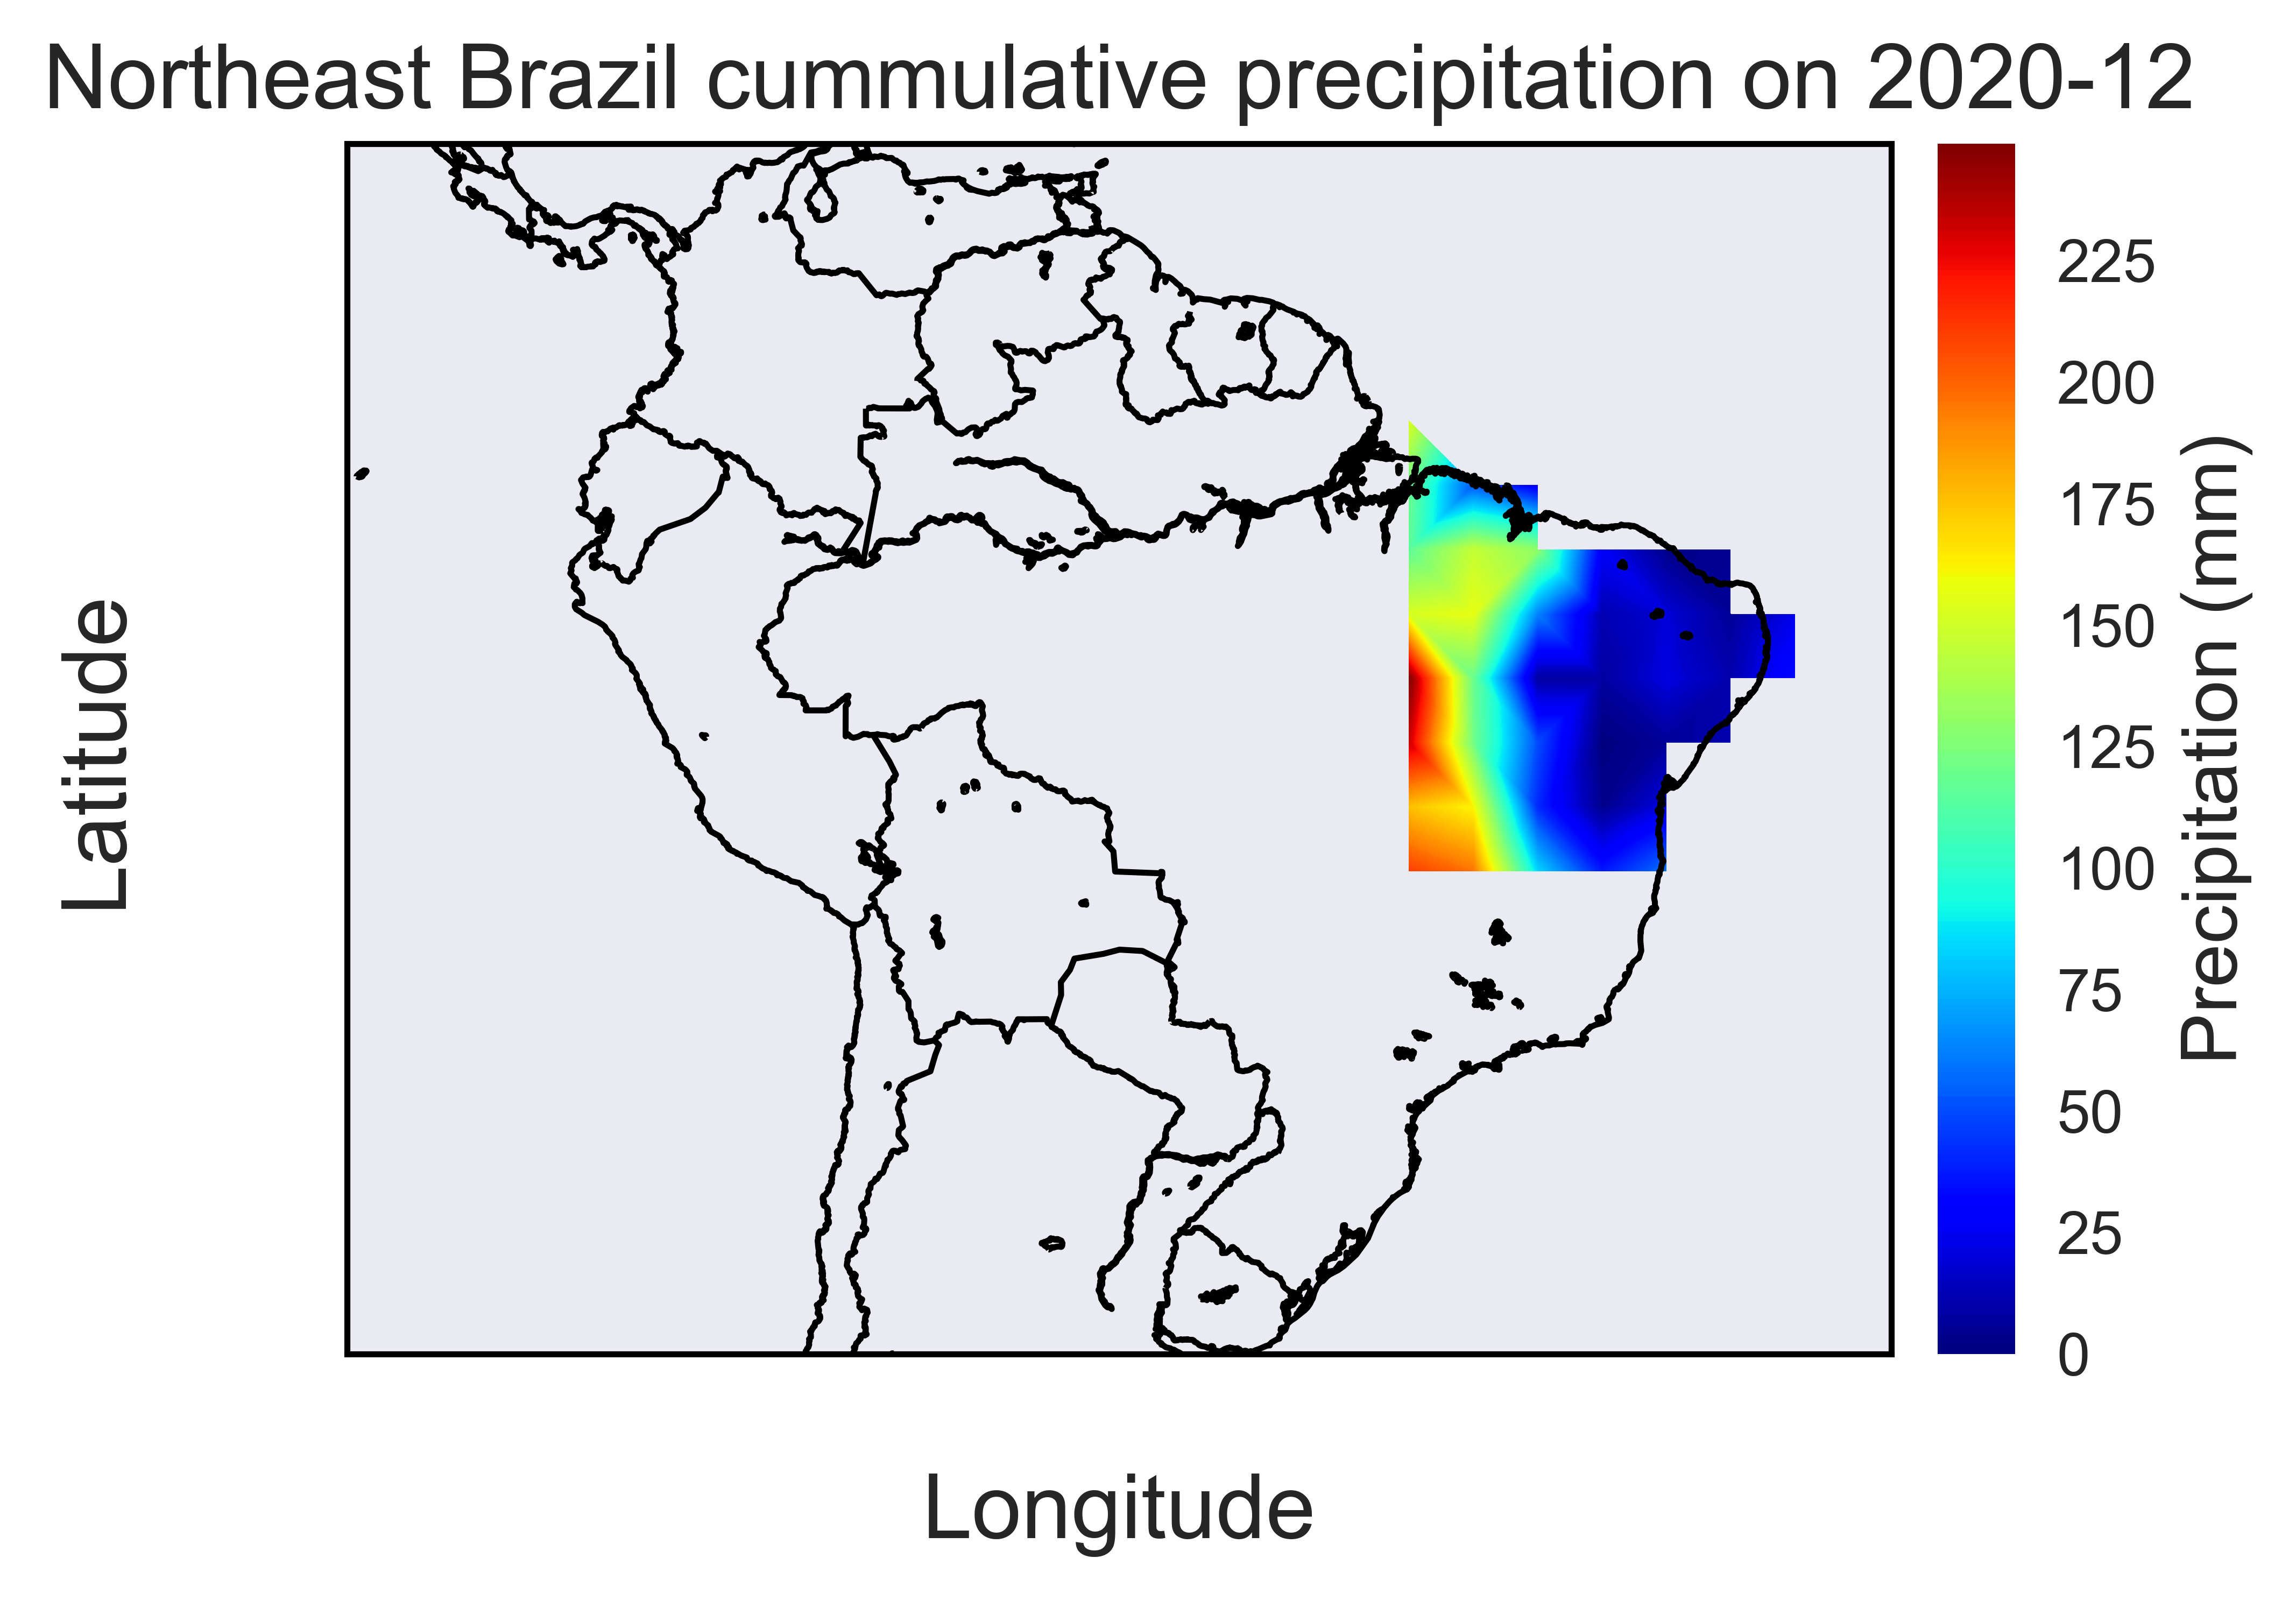

In [20]:
plot_basemap(df=northeast_brazil_data[northeast_brazil_data['time'] == '2020-12-01'],
             title='Northeast Brazil cummulative precipitation on 2020-12',
             score='precip',
             score_name='Precipitation (mm)',
             grid_size=1000,
             llcrnrlon=-90, 
             llcrnrlat=-35, 
             urcrnrlon=-30, 
             urcrnrlat=12,
             figsize_x=5,
             figsize_y=5)

## SPI calculation functions

In [21]:
def standardization(value, params):
    cdf_value = stats.gamma.cdf(value, *params)
    norm_spi = stats.norm.ppf(cdf_value, loc=0, scale=1)
    return norm_spi

def gamma_params(x, initial_est=True):
    if x.isna().sum() > 0:
        return [np.nan, np.nan, np.nan]
    elif initial_est:
        # Calculate sample mean and variance
        mean = np.mean(x)
        variance = np.var(x)

        # Calculate initial estimates for the gamma parameters
        initial_scale = variance/mean
        initial_loc = 0  # assuming data is not shifted

        # Fit the gamma distribution to the data using initial estimates
        try:
            shape, loc, scale = stats.gamma.fit(x, loc=initial_loc, scale=initial_scale)
        except:
            print('Failed to converge to distribution parameter domain')
            return [np.nan, np.nan, np.nan]
        return [shape, loc, scale]
    else:
        shape, loc, scale = stats.gamma.fit(x)
        return [shape, loc, scale]

def spi_table(initial_precip_table, fit_period=12, initial_est=True):

    precip_table = initial_precip_table.copy()
    precip_table.loc[:,'cumulative_precip'] = np.nan
    precip_table.loc[:,'SPI'] = np.nan

    iters = len(precip_table['lat'].unique())*len(precip_table['lon'].unique())
    print('Total iterations:', iters, '\n\n')
    counter = 0

    for lat in precip_table['lat'].unique():
        for lon in precip_table['lon'].unique():

            aux_df = pd.DataFrame()
            series = precip_table[(precip_table['lat']==lat) & (precip_table['lon']==lon)]['precip']

            # 12 months (1 year) cumulative precipitation
            aux_df.loc[:, 'cumulative_precip'] = series.rolling(fit_period, center=False).sum()

            # Fit gamma distribution for 12 months cumulative precipitation considering 360 months offset from t-12 backwards
            aux_df.loc[:,'gamma_params'] = [gamma_params(x, initial_est) for x in aux_df['cumulative_precip'].shift(12).rolling(window=360, center=False)]

            # Obtain spi using the gamma parameters fitted and the current 12 month precipitation value
            spi_value = aux_df.apply(lambda x: standardization(x.cumulative_precip, x.gamma_params), axis=1)

            # Sets the obtained SPI values on the final table
            precip_table.loc[(precip_table['lat']==lat) & (precip_table['lon']==lon), 'cumulative_precip'] = aux_df['cumulative_precip']
            precip_table.loc[(precip_table['lat']==lat) & (precip_table['lon']==lon), 'SPI'] = spi_value

            del aux_df

            counter+=1
            print('\nLat: ', lat, '  Lon: ', lon)
            print('Completeness', round(counter/iters, 4))
            
    return precip_table

<br>
<br>

### SPI based on 12 months cumulative rain

In [22]:
ca_precip_table = spi_table(northeast_brazil_data, fit_period=12)

Total iterations: 56 



Lat:  -6.25   Lon:  -33.75
Completeness 0.0179

Lat:  -6.25   Lon:  -36.25
Completeness 0.0357

Lat:  -6.25   Lon:  -41.25
Completeness 0.0536

Lat:  -6.25   Lon:  -38.75
Completeness 0.0714

Lat:  -6.25   Lon:  -46.25
Completeness 0.0893

Lat:  -6.25   Lon:  -43.75
Completeness 0.1071

Lat:  -6.25   Lon:  -48.75
Completeness 0.125

Lat:  -8.75   Lon:  -33.75
Completeness 0.1429

Lat:  -8.75   Lon:  -36.25
Completeness 0.1607

Lat:  -8.75   Lon:  -41.25
Completeness 0.1786

Lat:  -8.75   Lon:  -38.75
Completeness 0.1964

Lat:  -8.75   Lon:  -46.25
Completeness 0.2143

Lat:  -8.75   Lon:  -43.75
Completeness 0.2321

Lat:  -8.75   Lon:  -48.75
Completeness 0.25

Lat:  -11.25   Lon:  -33.75
Completeness 0.2679

Lat:  -11.25   Lon:  -36.25
Completeness 0.2857

Lat:  -11.25   Lon:  -41.25
Completeness 0.3036

Lat:  -11.25   Lon:  -38.75
Completeness 0.3214

Lat:  -11.25   Lon:  -46.25
Completeness 0.3393

Lat:  -11.25   Lon:  -43.75
Completeness 0.3571

Lat:  -11.25

In [23]:
ca_precip_table.to_csv('../data/processed/northeast_brazil_spi_12_gpcc.csv', index=False)

In [24]:
drought_series = ca_precip_table[['lat', 'lon', 'time', 'SPI']].copy()

In [31]:
k = -1.5
drought_series['drought'] = drought_series['SPI'].apply(lambda x: 1 if x <= k else 0)

<Axes: xlabel='time'>

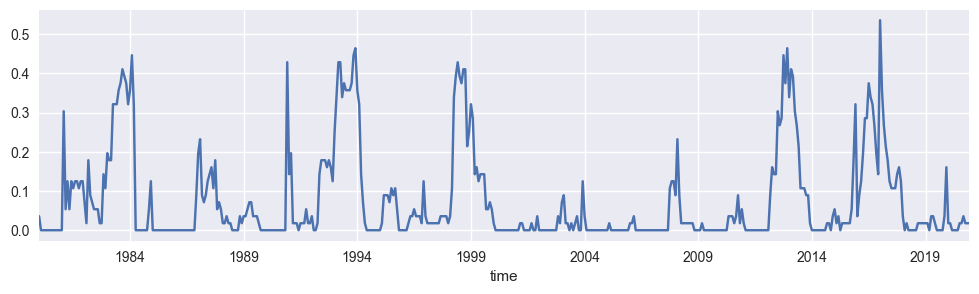

In [32]:
# drought_series[['time', 'drought']].groupby('time').apply(np.mean).plot(figsize=(12,3))
drought_series[['time', 'drought']][drought_series['time'] >= '1980-01-01'].groupby('time').apply(np.mean).plot(figsize=(12,3))

<br>
<br>

### SPI based on 24 months cumulative rain

In [33]:
ca_precip_table = spi_table(northeast_brazil_data, fit_period=24)

Total iterations: 56 



Lat:  -6.25   Lon:  -33.75
Completeness 0.0179

Lat:  -6.25   Lon:  -36.25
Completeness 0.0357

Lat:  -6.25   Lon:  -41.25
Completeness 0.0536

Lat:  -6.25   Lon:  -38.75
Completeness 0.0714

Lat:  -6.25   Lon:  -46.25
Completeness 0.0893

Lat:  -6.25   Lon:  -43.75
Completeness 0.1071

Lat:  -6.25   Lon:  -48.75
Completeness 0.125

Lat:  -8.75   Lon:  -33.75
Completeness 0.1429

Lat:  -8.75   Lon:  -36.25
Completeness 0.1607

Lat:  -8.75   Lon:  -41.25
Completeness 0.1786

Lat:  -8.75   Lon:  -38.75
Completeness 0.1964

Lat:  -8.75   Lon:  -46.25
Completeness 0.2143

Lat:  -8.75   Lon:  -43.75
Completeness 0.2321

Lat:  -8.75   Lon:  -48.75
Completeness 0.25

Lat:  -11.25   Lon:  -33.75
Completeness 0.2679

Lat:  -11.25   Lon:  -36.25
Completeness 0.2857

Lat:  -11.25   Lon:  -41.25
Completeness 0.3036

Lat:  -11.25   Lon:  -38.75
Completeness 0.3214

Lat:  -11.25   Lon:  -46.25
Completeness 0.3393

Lat:  -11.25   Lon:  -43.75
Completeness 0.3571

Lat:  -11.25

In [34]:
ca_precip_table.to_csv('../data/processed/northeast_brazil_spi_24_gpcc.csv', index=False)

In [35]:
drought_series = ca_precip_table[['lat', 'lon', 'time', 'SPI']].copy()

In [36]:
k = -1.5
drought_series['drought'] = drought_series['SPI'].apply(lambda x: 1 if x <= k else 0)

<Axes: xlabel='time'>

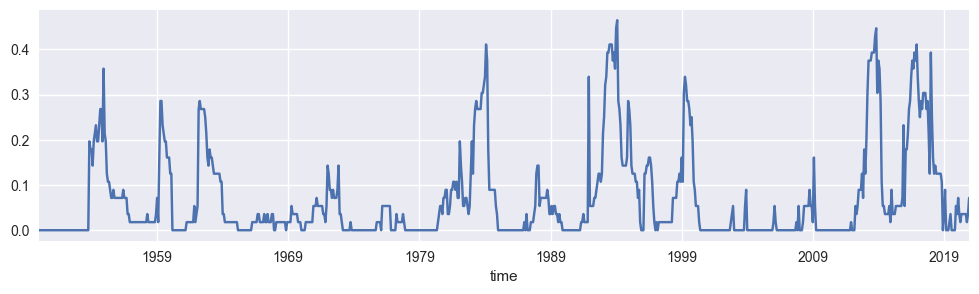

In [39]:
# drought_series[['time', 'drought']].groupby('time').apply(np.mean).plot(figsize=(12,3))
drought_series[['time', 'drought']][drought_series['time'] >= '1950-01-01'].groupby('time').apply(np.mean).plot(figsize=(12,3))